In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

import seaborn as sns
import matplotlib.pyplot as plt     

In [3]:
df = pd.read_csv("../../MalMem leaderboard/Obfuscated-MalMem2022.csv")
df.head()

,Category,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class
0,Benign,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,...,221,26,24,116,0,121,87,0,8,Benign
1,Benign,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,...,222,26,24,118,0,122,87,0,8,Benign
2,Benign,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,...,222,26,27,118,0,120,88,0,8,Benign
3,Benign,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,...,222,26,27,118,0,120,88,0,8,Benign
4,Benign,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,...,222,26,24,118,0,124,87,0,8,Benign


In [4]:
df['Category'] = ["_".join(i.split('-')[:2]) for i in df.Category.values]
del df['Class']
l = 0
label_mapper = {}
for i,j in df.Category.value_counts().items():
    label_mapper[i] = l
    l+=1
label_mapper

{'Benign': 0,
 'Spyware_Transponder': 1,
 'Spyware_Gator': 2,
 'Ransomware_Shade': 3,
 'Ransomware_Ako': 4,
 'Spyware_180solutions': 5,
 'Spyware_CWS': 6,
 'Trojan_Refroso': 7,
 'Trojan_Scar': 8,
 'Ransomware_Conti': 9,
 'Trojan_Emotet': 10,
 'Ransomware_Maze': 11,
 'Trojan_Zeus': 12,
 'Ransomware_Pysa': 13,
 'Trojan_Reconyc': 14,
 'Spyware_TIBS': 15}

In [5]:
df.Category.replace(label_mapper,inplace=True)
df["Category"] = pd.to_numeric(df["Category"])

In [6]:
label_mapper

{'Benign': 0,
 'Spyware_Transponder': 1,
 'Spyware_Gator': 2,
 'Ransomware_Shade': 3,
 'Ransomware_Ako': 4,
 'Spyware_180solutions': 5,
 'Spyware_CWS': 6,
 'Trojan_Refroso': 7,
 'Trojan_Scar': 8,
 'Ransomware_Conti': 9,
 'Trojan_Emotet': 10,
 'Ransomware_Maze': 11,
 'Trojan_Zeus': 12,
 'Ransomware_Pysa': 13,
 'Trojan_Reconyc': 14,
 'Spyware_TIBS': 15}

In [7]:
df.Category.value_counts()

0     29298
1      2410
2      2200
3      2128
4      2000
5      2000
6      2000
7      2000
8      2000
9      1988
10     1967
11     1958
12     1950
13     1717
14     1570
15     1410
Name: Category, dtype: int64

In [8]:
LEARNING_RATE = 0.001
EPOCHS = 10
BATCH_SIZE = 64
BUFFER_SIZE = int(BATCH_SIZE * 10)
NON_ZERO_DAY_CLASSES = [0,1,3,5,7,9]

In [9]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.mean(),inplace=True)

df_ = df[df.Category.isin(NON_ZERO_DAY_CLASSES)]

X = df_.iloc[:,1:]
y = df_.iloc[:,0]
y[y!=0] = 1
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=128)

zero = df[~df.Category.isin(NON_ZERO_DAY_CLASSES)]
X_zero = zero.iloc[:,1:]
y_zero = np.ones(X_zero.shape[0])

C:\Users\axylo\AppData\Local\Temp\ipykernel_17284\983842108.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y!=0] = 1


In [10]:
ls = len(y_train[y_train == 1])
sz = int(ls + ls * 0.1)

In [11]:
print(np.unique(y_train,return_counts=True))
X_train_d = pd.concat([X_train[y_train==0].sample(n=sz),X_train[y_train==1]])
y_train_d = np.concatenate([np.zeros(sz),np.ones(ls)])
print(np.unique(y_train_d,return_counts=True))

(array([0, 1], dtype=int64), array([23412,  8447], dtype=int64))
(array([0., 1.]), array([9291, 8447], dtype=int64))


In [12]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train_d)
X_valid_sc = sc.transform(X_valid)
X_zero_sc = sc.transform(X_zero)

In [13]:
tem = X_valid_sc[y_valid==0]
X_test_sc = np.concatenate((tem, X_zero_sc), axis=0)
y_test = np.concatenate((np.zeros(tem.shape[0]),np.ones(X_zero_sc.shape[0])))

In [14]:
X_train_sc, y_train_d = shuffle(X_train_sc, y_train_d)
X_valid_sc, y_valid = shuffle(X_valid_sc, y_valid.values)
X_test_sc, y_test = shuffle(X_test_sc, y_test)

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_sc,y_train_d))
train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_sc, y_valid))
valid_dataset = valid_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_sc, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
class AccentuatedLayer(tf.keras.layers.Layer):
    def __init__(self, emb_dim, kernels, name=None):
        super(AccentuatedLayer, self).__init__(name=name)
        self.emb_dim = emb_dim
        self.projected_emb = tf.keras.layers.Dense(emb_dim, activation='tanh', trainable=True)
        self.pattern_kernels = tf.Variable(tf.random_normal_initializer()(shape=[kernels,emb_dim], dtype=tf.float32)
                                           ,trainable=True)
    
    def compute_cosine_sim(self, a, b):
        normalize_a = tf.nn.l2_normalize(a,1)        
        normalize_b = tf.nn.l2_normalize(b,1)
        sim = tf.matmul(normalize_a, normalize_b, transpose_b=True)
        return sim
    
    def call(self, inputs, hidden_smx=None):
        embs = self.projected_emb(inputs)
        similarity = self.compute_cosine_sim(embs,self.pattern_kernels)
        smx = tf.math.softmax(similarity)
        if hidden_smx is None:
            cell_outs = tf.einsum('ij,ik->ikj', embs, smx)
            return cell_outs, smx
        else:
            sidx = tf.argsort(hidden_smx)
            weighted_scores = tf.gather(tf.cumsum(tf.sort(hidden_smx,axis=1),axis=1),sidx,axis=1, batch_dims = 1)
            sofsm = tf.einsum("ij,ijk->ijk",weighted_scores,smx)
            cell_outs = tf.reduce_sum(tf.einsum("ijk,ijl->ijlk",embs,sofsm),axis=1)
            return cell_outs, tf.reduce_sum(smx,axis=1)

In [17]:
inp_layer = tf.keras.layers.Input(shape=(X_test_sc.shape[1],))

ac_vec, hid= AccentuatedLayer(32,kernels=16,name=f"AccentLayer1")(inp_layer)
ac_vec, hid = AccentuatedLayer(16,kernels=8,name=f"AccentLayer2")(ac_vec, hid)
dp = tf.keras.layers.Dropout(0.2)(ac_vec)

flt = tf.keras.layers.Flatten()(dp)
outl = tf.keras.layers.Dense(1,activation='sigmoid')(flt)

model = tf.keras.Model(inputs=inp_layer,outputs=outl)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55)]         0                                            
__________________________________________________________________________________________________
AccentLayer1 (AccentuatedLayer) ((None, 16, 32), (No 2304        input_1[0][0]                    
__________________________________________________________________________________________________
AccentLayer2 (AccentuatedLayer) ((None, 8, 16), (Non 656         AccentLayer1[0][0]               
                                                                 AccentLayer1[0][1]               
__________________________________________________________________________________________________
dropout (Dropout)               (None, 8, 16)        0           AccentLayer2[0][0]           

In [18]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     LEARNING_RATE,
#     decay_steps=30000,
#     decay_rate=0.96,
#     staircase=True)

In [20]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),metrics=['acc'])

In [21]:
history = model.fit(train_dataset,epochs=EPOCHS, validation_data=valid_dataset)

Epoch 1/10
278/278 [==============================] - 6s 13ms/step - loss: 0.2479 - acc: 0.9485 - val_loss: 0.0249 - val_acc: 0.9959
Epoch 2/10
278/278 [==============================] - 4s 13ms/step - loss: 0.0279 - acc: 0.9945 - val_loss: 0.0129 - val_acc: 0.9951
Epoch 3/10
278/278 [==============================] - 4s 14ms/step - loss: 0.0166 - acc: 0.9951 - val_loss: 0.0194 - val_acc: 0.9921
Epoch 4/10
278/278 [==============================] - 4s 13ms/step - loss: 0.0147 - acc: 0.9959 - val_loss: 0.0106 - val_acc: 0.9956
Epoch 5/10
278/278 [==============================] - 4s 13ms/step - loss: 0.0146 - acc: 0.9955 - val_loss: 0.0114 - val_acc: 0.9965
Epoch 6/10
278/278 [==============================] - 4s 13ms/step - loss: 0.0124 - acc: 0.9958 - val_loss: 0.0141 - val_acc: 0.9962
Epoch 7/10
278/278 [==============================] - 4s 13ms/step - loss: 0.0114 - acc: 0.9966 - val_loss: 0.0075 - val_acc: 0.9984
Epoch 8/10
278/278 [==============================] - 4s 14ms/step - 

In [22]:
y_valid_pred = np.array(model.predict(valid_dataset)>0.5,dtype=np.int32)

In [23]:
print(classification_report(y_valid,y_valid_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5886
           1       0.99      1.00      0.99      2079

    accuracy                           1.00      7965
   macro avg       0.99      1.00      1.00      7965
weighted avg       1.00      1.00      1.00      7965



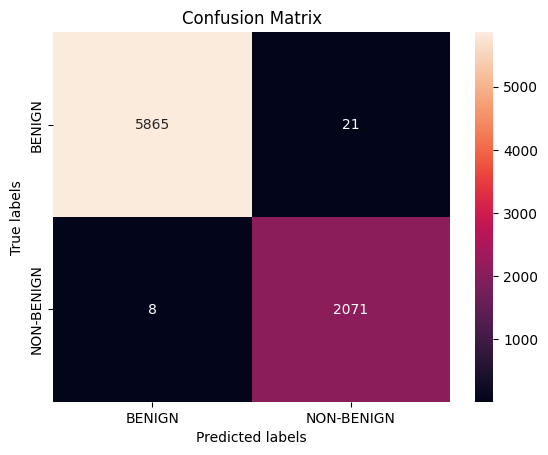

In [24]:
cm = confusion_matrix(y_valid,y_valid_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

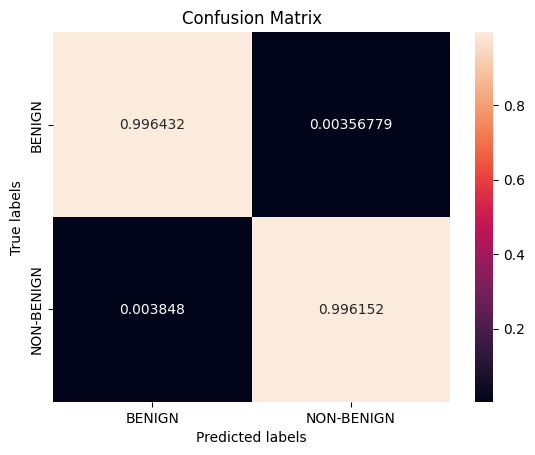

In [25]:
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

In [26]:
y_test_pred_prob = model.predict(test_dataset)

In [27]:
y_test_pred = np.array(y_test_pred_prob>0.5,dtype=np.int32)

In [28]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      5886
         1.0       1.00      1.00      1.00     18772

    accuracy                           1.00     24658
   macro avg       0.99      1.00      1.00     24658
weighted avg       1.00      1.00      1.00     24658



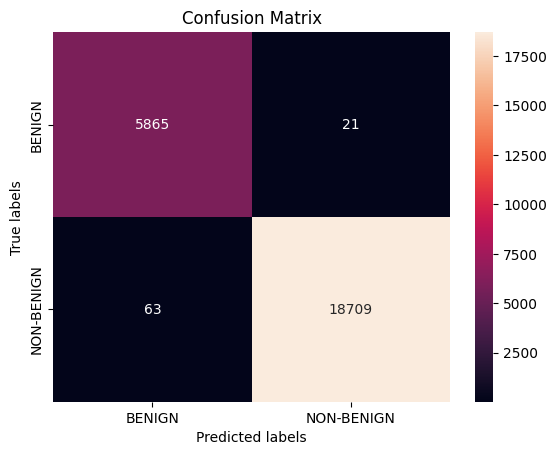

In [29]:
cm = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

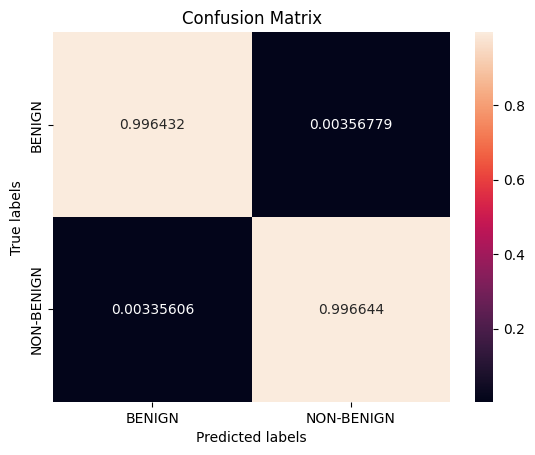

In [30]:
ax= plt.subplot()
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='g', ax=ax)

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']); 
ax.yaxis.set_ticklabels(['BENIGN', 'NON-BENIGN']);

In [31]:
accuracy_score(y_test,y_test_pred),f1_score(y_test,y_test_pred)

(0.996593397680266, 0.9977601194602955)